In [85]:
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import krippendorff

In [86]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"

# Tweets

In [87]:
src = "../../data/tweets"
fname = "US_politician_tweets_2010-11-06_to_2022-03-16.csv.gzip"
tweets = pd.read_csv(join(src, fname), compression="gzip", parse_dates=["created_at"])

In [88]:
print(f"number of tweets in the corpus: {len(tweets)}")
print("number of original in the corpus: {}"\
      .format(len(tweets[(tweets["retweeted"] == False) &\
                         (tweets["quoted"] == False) &\
                         (tweets["reply"] == False)])))
print("number of quoted tweets in the corpus: {}"\
      .format(len(tweets[tweets["quoted"] == True])))
print("number of replies in the corpus: {}"\
      .format(len(tweets[tweets["reply"] == True])))
print("number of retweets in the corpus: {}"\
      .format(len(tweets[tweets["retweeted"] == True])))

number of tweets in the corpus: 2588559
number of original in the corpus: 1523050
number of quoted tweets in the corpus: 266737
number of replies in the corpus: 248511
number of retweets in the corpus: 552892


In [89]:
# drop retweets
N = len(tweets)
tweets = tweets[tweets["retweeted"] == False]
print(f"dropped {N - len(tweets)} retweets")

dropped 552892 retweets


In [90]:
len(tweets["author_id"].unique())

1034

In [91]:
tweets["year"] = pd.to_datetime(tweets["created_at"]).dt.year

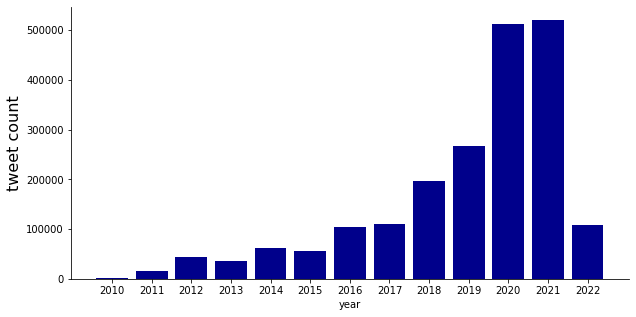

In [92]:
counts, years = np.histogram(tweets["year"], bins=range(2010, 2022))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(tweets["year"].value_counts(ascending=True).index,
       tweets["year"].value_counts(ascending=True).values,
       color="DarkBlue")
ax.set_xticks(range(2010, 2023))
ax.set_ylabel("tweet count", fontsize=16)
ax.set_xlabel("year", fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [93]:
# drop tweets without honesty component (distill RoBERTa filtering)
N = len(tweets)
tweets = tweets.dropna(subset=["belief", "truth"])
print(f"dropped {N - len(tweets)} tweets without an honesty component")

dropped 210867 tweets without an honesty component


In [94]:
# set tweet creation date as index for easier sampling and aggregation
tweets = tweets.set_index("created_at")

In [95]:
# drop tweets from 2010
N = len(tweets)
tweets = tweets[tweets.index.year > 2010]
print(f"dropped {N - len(tweets)} tweets from before 2011")

dropped 778 tweets from before 2011


In [96]:
print(f"N tweets in final corpus {len(tweets)}")

N tweets in final corpus 1824022


In [97]:
tweets["belief"].sum()

131626.0

In [98]:
tweets["truth"].sum()

273192.0

In [38]:
len(tweets[(tweets["belief"] == 1) & (tweets["truth"] == 1)])

19653

In [83]:
del tweets

# Articles

In [79]:
src = "../../data/articles"
fname = "full_links_with_text_and_honesty.csv.gzip"
cols = ["belief", "truth", "other_words", "wc", "belief_prop", "truth_prop",
        "NG_score", "url", "party"]
texts = pd.read_csv(join(src, fname), usecols=cols, compression="gzip")

In [80]:
len(texts)

162508

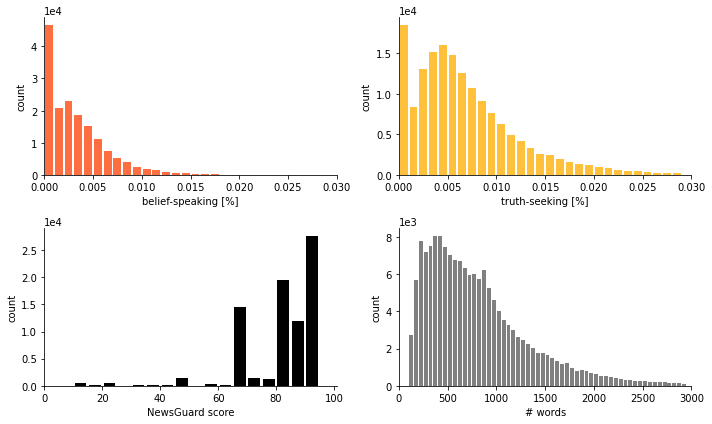

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0][0].hist(texts["belief_prop"], bins=np.arange(0, 0.03, 0.001), 
                rwidth=0.8, color="#ff6e40")
axes[0][0].set_xlim(0, 0.03)
axes[0][0].set_xlabel("belief-speaking [%]")

axes[0][1].hist(texts["truth_prop"], bins=np.arange(0, 0.03, 0.001), 
                rwidth=0.8, color="#ffc13b")
axes[0][1].set_xlim(0, 0.03)
axes[0][1].set_xlabel("truth-seeking [%]")

axes[1][0].hist(texts["NG_score"], bins=np.arange(0, 100, 5),
                rwidth=0.8, color='k')
axes[1][0].set_xlim(0, 101)
axes[1][0].set_xlabel("NewsGuard score")

axes[1][1].hist(texts["wc"], bins=np.arange(0, 3000, 50),
                rwidth=0.8, color="grey")
axes[1][1].set_xlim(0, 3001)
axes[1][1].set_xlabel("# words")
for ax in axes.flatten():
    ax.set_ylabel("count")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
fig.tight_layout()

In [82]:
del texts

# NewsGuard nutrition scores

In [41]:
# load the nutrition labels
src = "../../data/utilities"
fname = "NewsGuard_labels.csv"
NG_scores = pd.read_csv(join(src, fname))
# if more than one score exists for the same domain, keep the most recent one
NG_scores = NG_scores.sort_values(by=["Domain","Last Updated"], ascending=False)
NG_scores = NG_scores.drop_duplicates(subset=["Domain"])

# threshold scores at various cutoffs to define untrustworthy domains
NG_scores["NewsGuard_unreliable"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "NewsGuard_unreliable"] = 1
unreliable_60_domains = set(NG_scores[NG_scores["NewsGuard_unreliable"] == 1]["Domain"])

In [42]:
number_of_english_domains = NG_scores["Language"].value_counts().loc["en"]

unreliable_60 = len(NG_scores[(NG_scores["Language"] == "en") &\
                        (NG_scores["Score"] < 60)]) / \
                        len(NG_scores[NG_scores["Language"] == "en"])

print("The NewsGuard dataset as of 2022-03-01 contains {} english entries"\
        .format(number_of_english_domains))
print("{:1.2f} % ({}) of English entries have a score < 60"\
        .format(unreliable_60 * 100, len(unreliable_60_domains)))

The NewsGuard dataset as of 2022-03-01 contains 6860 english entries
37.24 % (2757) of English entries have a score < 60


Text(15, 2000, 'not trustworthy')

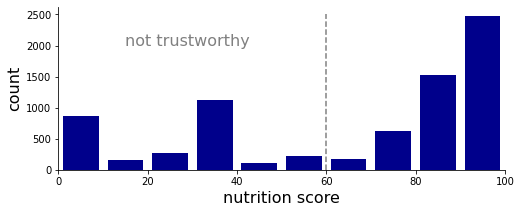

In [43]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(NG_scores["Score"], rwidth=0.8, color="DarkBlue")
ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("count", fontsize=16)
ax.set_xlabel("nutrition score", fontsize=16)
ax.plot([60, 60], [0, 2500], '--', color="grey")
ax.text(15, 2000, "not trustworthy", color="grey", fontsize=16)

# Alternative trustworthiness labels

In [44]:
# load the list of independently compiled trustworthiness labels for 
# news sources
src = "../../data/utilities"
fname = "independent_labels.csv"
alt_labels = pd.read_csv(join(src, fname))
alt_labels = alt_labels.rename(columns = {"type":"unreliable", "url":"Domain"})

# convert reliability labels to binary
alt_labels["unreliable"] = alt_labels["unreliable"]\
    .replace({"reliable":0, "unreliable":1})
N_alt_labels = len(alt_labels)
N_alt_untrustworthy = alt_labels["unreliable"].value_counts().loc[1]

In [46]:
NG_domains = set(NG_scores["Domain"])
alt_domains = set(alt_labels["Domain"])
shared_domains = len(NG_domains.intersection(alt_domains))
untrustworthy_domains = set(alt_labels[alt_labels["unreliable"] == 1]["Domain"])
shared_untrustworthy_domains_60 = len(fishy_60_domains\
                                   .intersection(untrustworthy_domains))

In [47]:
print(f"The alternative list contains {N_alt_labels} domains")
print(f"Out of which {N_alt_untrustworthy} are labelled 'untrustworthy'")
print(f"{shared_domains} domains are also indexed by NewsGuard")
print(f"{shared_untrustworthy_domains_60} untrustworthy domains are also indexed by NewsGuard (score < 60)")

The alternative list contains 4767 domains
Out of which 2170 are labelled 'untrustworthy'
1677 domains are also indexed by NewsGuard
566 untrustworthy domains are also indexed by NewsGuard (score < 60)


# Comparison NewsGuard <-> alternative labels

In [48]:
alt_domains = set(alt_labels["Domain"])

In [49]:
len(alt_domains)

4767

In [50]:
alt_labels["unreliable"].value_counts()

0    2597
1    2170
Name: unreliable, dtype: int64

In [51]:
NG_domains = set(NG_scores["Domain"])

In [52]:
in_both = alt_domains.intersection(NG_domains)
len(in_both)

1677

In [53]:
alt_labels[alt_labels["Domain"].isin(list(NG_domains))]["unreliable"].value_counts()

0    1062
1     615
Name: unreliable, dtype: int64

In [54]:
alt_labels["unreliable"] = alt_labels["unreliable"].replace({
    "reliable":0,
    "unreliable":1
})

In [55]:
NG_scores["unreliable"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "unreliable"] = 1

In [56]:
labels_NG = NG_scores[NG_scores["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
labels_ind = alt_labels[alt_labels["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
joint_labels = pd.DataFrame({
    "label_NG":labels_NG["unreliable"].values,
    "label_ind":labels_ind["unreliable"].values})

same = len(joint_labels[joint_labels["label_NG"] == joint_labels["label_ind"]])
kripp = krippendorff.alpha(joint_labels.transpose())
print(f"number of same labels: {same}, krippendorff's alpha: {kripp}")

number of same labels: 1553, krippendorff's alpha: 0.8422170341180256


# Unreliable links

In [64]:
unreliable_user_count = tweets[["author_id", "NG_unreliable"]]\
    .groupby("author_id")\
    .agg(["sum", "count"])

unreliable_user_count["unreliable_60_share"] = \
            unreliable_user_count["NG_unreliable"]["sum"] / \
            unreliable_user_count["NG_unreliable"]["count"]
    
# flatten the hierarchical indices
unreliable_user_count = unreliable_user_count.reset_index()
unreliable_user_count.columns = ['_'.join(col).strip("_") \
                            for col in unreliable_user_count.columns.values]

unreliable_user_count.head(2)

,author_id,NG_unreliable_sum,NG_unreliable_count,unreliable_60_share
0,4107251,6.0,256,0.023438
1,5558312,1.0,316,0.003165


In [66]:
score_cutoff = 60
N_no_shares = len(unreliable_user_count[\
                unreliable_user_count[f"unreliable_{score_cutoff}_share"] == 0])
print("{}/{} did not share any unreliable links ({})"\
         .format(N_no_shares, len(unreliable_user_count), score_cutoff))

max_share = unreliable_user_count[f"unreliable_{score_cutoff}_share"].max()
print("the most unreliable user has {:1.2f}% tweets with unreliable links ({})"\
      .format(max_share * 100, score_cutoff))

406/1035 did not share any unreliable links (60)
the most unreliable user has 42.54% tweets with unreliable links (60)


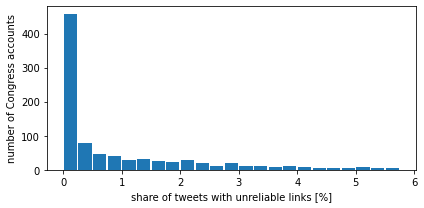

In [70]:
fig, ax = plt.subplots(1, figsize=(6, 3))

ax.hist(unreliable_user_count["unreliable_60_share"] * 100, 
        bins=np.arange(0, 6, 0.25), rwidth=0.9)
ax.set_xlabel(f"share of tweets with unreliable links [%]")
ax.set_ylabel("number of Congress accounts")
fig.tight_layout()

# Ideology scores

In [72]:
src = "../../data/utilities"
fname = "govtrack-stats-{}-{}-ideology.csv"
scores = pd.DataFrame()
for year in range(2013, 2021):
    for chamber in ["house", "senate"]:
        tmp = pd.read_csv(join(src, "ideology_scores",
                               fname.format(year, chamber)))
        tmp["year"] = year
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("b'", ""))
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("'", "").lower())
        scores = pd.concat([scores, tmp])

In [73]:
src = "../../data/users"
fname = "US_politician_accounts_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(join(src, fname))

In [74]:
scores = pd.merge(
    scores, 
    users[["party", "handle", "author_id", "ideology_score_id"]]\
        .drop_duplicates(subset=["ideology_score_id"]),
    how="left",
    left_on="id",
    right_on="ideology_score_id"
)

In [75]:
scores = scores.sort_values(by=["handle", "year"])

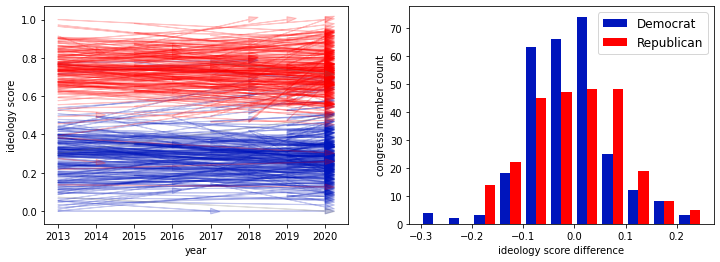

In [76]:
subset = scores.dropna(subset=["party"])
subset = subset.set_index("handle")
dem = subset[subset["party"] == "Democrat"]
rep = subset[subset["party"] == "Republican"]
ind = subset[subset["party"] == "Independent"]

diffs = pd.DataFrame(columns=["party", "ideology"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
for dataset, color, party in zip([dem, rep, ind],
                                 [demblue, repred, indgrey],
                                 ["Democrat", "Republican", "Independent"]): 
    for handle in dataset.index.unique():
        user_data = dataset.loc[handle]
        if type(user_data) != pd.core.series.Series:
            x1 = user_data.iloc[0]["year"]
            x2 = user_data.iloc[-1]["year"] - x1
            y1 = user_data.iloc[0]["ideology"]
            y2 = user_data.iloc[-1]["ideology"] - y1
            
            diffs = pd.concat([diffs, pd.DataFrame({
                "party":[party],
                "ideology_difference":[y2]})])

        ax.arrow(x1, y1, x2, y2, color=color, alpha=0.2, 
                 width=0.001, head_width=0.03, head_length=0.25)
ax.set_ylabel("ideology score")
ax.set_xlabel("year")
        
ax = axes[1]
dem = diffs[diffs["party"] == "Democrat"]
rep = diffs[diffs["party"] == "Republican"]
ind = diffs[diffs["party"] == "Independent"]

ax.hist([dem["ideology_difference"], rep["ideology_difference"]],
        color=[demblue, repred], bins=np.arange(-0.3, 0.3, 0.05),
        label=["Democrat", "Republican"])
ax.set_ylabel("congress member count")
ax.set_xlabel("ideology score difference")
ax.legend(fontsize=12)

In [77]:
diffs.groupby("party").agg("mean")

,ideology_difference
party,
Democrat,-0.007609
Independent,0.018028
Republican,0.001964


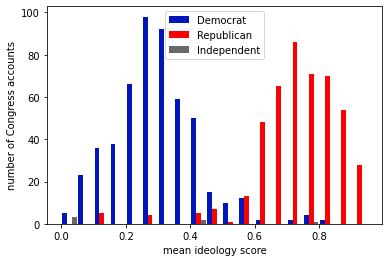

In [78]:
fig, ax = plt.subplots()
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]
ind = users[users["party"] == "Independent"]
ax.hist([dem["ideology_mean"], rep["ideology_mean"], ind["ideology_mean"]], 
        bins=np.arange(0, 1, 0.05), rwidth=0.9, 
        label=["Democrat", "Republican", "Independent"],
        color=[demblue, repred, indgrey])
ax.set_xlabel("mean ideology score")
ax.set_ylabel("number of Congress accounts")
ax.legend();